In [1]:
import shlex
import time
from typing import Tuple, Union

import torch.nn
from torch.utils.data import DataLoader

from GTTA import config_summoner
from GTTA.data import load_dataset, create_dataloader
from GTTA.utils.load_manager import load_pipeline, load_tta_algorithm, load_model, load_alg
from GTTA.utils.args import args_parser
from GTTA.utils.config_reader import Conf
from GTTA.utils.initial import reset_random_seed
from GTTA.utils.logger import load_logger
from GTTA.definitions import OOM_CODE
from GTTA.kernel.main import initialize_model_dataset

argv = shlex.split('--task train --config_path TTA_configs/CMNIST/TICP.yaml --gpu_idx 4 --exp_round 1')
print(argv)
args = args_parser(argv)
config = config_summoner(args)
model, loader = initialize_model_dataset(config)
ood_algorithm = load_alg(config.ood.alg, config)

ticp = load_tta_algorithm(config.tta.name, config.task, model, loader, ood_algorithm, config)

/data/shurui.gui/anaconda3/envs/torch_110/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['--task', 'train', '--config_path', 'TTA_configs/CMNIST/TICP.yaml', '--gpu_idx', '4', '--exp_round', '1']


/data/shurui.gui/Projects/TTA/GraphTTA/GTTA/utils/config_reader.py:176: UserWarning: Missing argument "config_path" in the config file.
/data/shurui.gui/Projects/TTA/GraphTTA/GTTA/utils/config_reader.py:172: UserWarning: Missing argument "test_ckpt" in the config file.
/data/shurui.gui/Projects/TTA/GraphTTA/GTTA/utils/config_reader.py:172: UserWarning: Missing argument "id_test_ckpt" in the config file.
/data/shurui.gui/Projects/TTA/GraphTTA/GTTA/utils/config_reader.py:172: UserWarning: Missing argument "full_clean" in the config file.
/data/shurui.gui/Projects/TTA/GraphTTA/GTTA/utils/config_reader.py:172: UserWarning: Missing argument "log_path" in the config file.
/data/shurui.gui/Projects/TTA/GraphTTA/GTTA/utils/config_reader.py:172: UserWarning: Missing argument "tensorboard_logdir" in the config file.
/data/shurui.gui/Projects/TTA/GraphTTA/GTTA/utils/config_reader.py:176: UserWarning: Missing argument "model.model_level" in the config file.
/data/shurui.gui/Projects/TTA/GraphTTA/G

#IN#
-----------------------------------
    Task: train
Wed Mar 29 22:47:12 2023
#IN#Load Dataset ColoredMNIST
#D#Dataset: {'train': <torch.utils.data.dataset.ConcatDataset object at 0x7f4126ff2e80>, 'test': <torch.utils.data.dataset.ConcatDataset object at 0x7f4126ff2df0>, 'metric': 'Accuracy', 'task': 'Binary classification'}
#D# (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([1.]))
#IN#Loading model...
MNIST_CNN(
  (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d

In [2]:
train_or_load = 'load'
ticp.train_vae(train_or_load)
ticp.mu_all, ticp.logvar_all = ticp.record_feature_distributions(train_or_load)
ticp.pseudo_environments = ticp.create_pseudo_environments(train_or_load)
ticp.train_linear_classifiers(ticp.pseudo_environments, train_or_load)

In [31]:
data = next(iter(ticp.loader['train']))[0].to(ticp.config.device)

In [32]:
print(data.shape)

torch.Size([64, 2, 28, 28])


In [33]:
import numpy as np
import torch

@torch.no_grad()
def show_image(data, id):
    import matplotlib.pyplot as plt
    img = data.cpu().numpy()[id]
    # expand the batchsize * 2 * 28 * 28 image into batchsize * 3 * 28 * 28 where the 3rd channel is all 0s
    img = np.concatenate((img, np.zeros((1, img.shape[1], img.shape[2]))), axis=0)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.show()

tensor([ 1.2817, -0.1877,  1.1823,  0.5514,  0.5829, -0.0219, -0.1521,  0.2972,
        -1.0451, -1.1534], device='cuda:4')


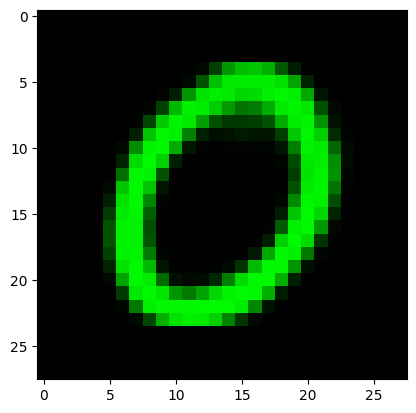

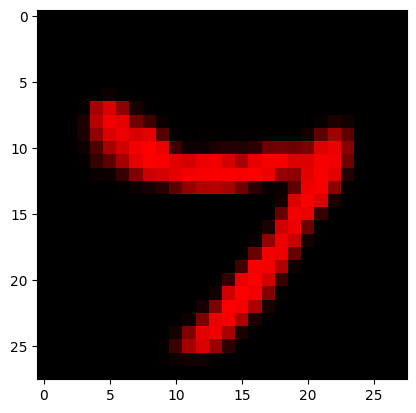

In [56]:
ticp.vae.eval()
i = 2
with torch.no_grad():
    mu, logvar, z = ticp.vae.get_posterior_z(data)
    gen_data = ticp.vae.decoder(z)
    print(z[i])
    intervened_z = z.clone().detach()
    # Only features 1 (shape) and 4 (color) matter
    intervened_z[i][1] = -4
    intervened_z[i][4] = -0.5
    intervened_data = ticp.vae.decoder(intervened_z)
    show_image(gen_data, i)
    show_image(intervened_data, i)